# DOING
2024-05-12 reliability over time for no replenishment s too high, even for 8 spacecraft check code

## WP03.04 Reliability in Distributed Spacecraft Missions (DSM)

This is an update assessment for the reliabiilty over time for a FireSat-II like mission, based on the orbital analysis for the AoI over the Brazilian Amazonia with a requierement of having 8 cubesat operational in order to provide the coverage and temporal resolution (twice a day).
Done may 12th, 2024

The purpose of this program is to get the reliability of several scenarios of a DSM configuration. It is done by setting the inputs of the several scenarios that makes up the DSM and outputs a summary table and a graph that plots the reliability curves of such systems. Unlike the conclusions established by Bouwmeester et al. [2022] on how to attack the reliability problem of CubeSat, which is the improvement of pre-launch tests; this work will delve into another option to improve it, which is to release more elements periodically. Considering this and everything mentioned above is that a new architecture is presented, detailed in its operation and purpose, that incorporates design and mission considerations as well as its limitations. The architecture is depicted initially in the Input-Process-Output Diagram (IPO) shown up next and further developed in the next sections.


Figure XX: IPO for reliability assessment of DSMs
Source: https://udeconce-my.sharepoint.com/:u:/g/personal/alelopez_udec_cl/EZOv2uAob3hEps1O5Qn-3EUBSP8dR5mC2TeSKWgq9N5wHA?e=Ji6n1k 
![
    INPUT PROCESS OUTPUT (IPO) Diagram for realiability assessment of Distributed Spacecraft Missions
](
    images/WP03.05IPOReliability-rev20240508.png
)

### 1. Setup
The program begins by setting the necessary libraries and tools in order for it to work. These variables mentioned start blank at the beginning of each iteration. 
- **iteration**: string that asks whether the user wants to try another DSM configuration
- **graph_labels**: array that compiles the configuration parameters entered to be later used as the graph's label.
- **cont**: variable used in the iteration of a final graph.
- **year_to_month**: a conversion, self-explained.


In [71]:
from matplotlib import pyplot as plt
import numpy as np
import scipy as sp
from IPython.display import Markdown
import pandas as pd
R_simulation = []
iteration = ''
graph_labels = []
year_to_month = 12

### 2. Inputs
It is important to remark that, in order for the notebook to work properly, all input arrays and mission strategy arrays must have the same number of elements. Each column represents a different scenario.

#### 2.1. Mission Time
This input sets how much time does the distributed mission lasts, in years. This provides the timeframe for the simulation to work, later represented in months.

In [72]:
Mission_time = 8
Time_months = np.arange(0, Mission_time * year_to_month)

#### 2.2. First Batch of Satellites Launched
This input determines how many CubeSats satellites are to be launched at time 0.

In [73]:
DSM_initial_amount = [8, 8, 2, 4, 8, 8, 8, 8] #Firesat-II over amazonia all DSM start with 8 sats to have 2 times a day pass

#### 2.3. Launch Costs
For displaying an estimation of the launch costs with different strategies, it is important to define several variables that reflect the launch of new elements to the system. The cost estimations are based on the launch of a 3U CubeSat to SSO orbit and written in kUSD.

In [74]:
Pod_cost = 150 #ref spaceflight 2022 http://spaceflight.com/schedule-pricing/
EPS_cost = 50
SpaceX_cost = 300

#### 2.4. CubeSat Reliability Curve

The methodology applied in this work is based of Bouwmeester et al. [2022] work, where they estimated the shape and properties of the CubeSat system and subsystem reliability curves, shown in the next graphs respectively, where they determined the shaped as a Lognormal-Gompertz product mixture and the curves for each subsystem as a bayesian inference out of the system's curve.


![
    Reliability curves for system and subsystem. Source: Bouwmeester et al. 2022
](
    images/relcurves.png
)


Therefore, this work starts by the use of such curves, starting by defining the relationship between subsystems in a CubeSat as in series, where:
$$
R_{sat}(t) = \prod_{n}^{i}R_{subsys, i}(t)
$$
Where $R_{sys}$ represents the reliability of the CubeSat and $R_i$ represents the reliability of the n-th subsystem, both obtained by Bouwmeester et al. (2022). Graphically the systems are represented in the next picture.


![
    Representation of a Series System proposed by Bouwmeester et al (2022). Source: the author.
](
    images/series-system.png
)


At the same time the model of the reliability obtained by the authors corresponds to a Lognormal-Gompertz product mixture, shown up next:
$$
R_{subsys}(t) = e^{-\eta\left ( e^{\frac{t}{\theta}} -1 \right ) }* \frac{1}{\sigma\sqrt{2\pi}}\int_{0}^{t}\frac{2}{x}e^{-\frac{\left ( \ln{x} - \mu \right )^2}{4\sigma^2}}dx
$$
Where $\theta$, $\eta$, $\sigma$, $\mu$ are variables that determines the curve for each subsystem and determined by the authors. In the code down below, they are expressed as arrays where each column is for each subsystem in this order:
- Attitude, Determination and Control Subsystem (ADCS)
- Control and Data Handling Subsystem (CDHS)
- Communications Subsystem (COMMS)
- Structure and Mechanisms Subsystem (STS)
- Mission Payload (P/L)
- Power Subsystem (EPS)

Based on Bouwmeester et al. (2022), the Thermal Subsystem and Propulsion Subsystem are missing in the database because either these subsystems are typically passive in CubeSats, embedded in other subsystems or not typically applied in this framework. The electrical interfaces between subsystems are also allocated to the major subsystems (e.g. data interfaces to CDHS, power distribution to EPS). Guidance, Navigation and Control was allocated inside the Attitude, Determination and Control Subsystem since they commonly share the same instruments (Star tracker for instance). For this work the nomenclature between the CubeSat Failure Database and the CubeSat Reference Model has been changed when referencing Bouwmeester et al. (2022) work, showing the translation in the next table.

|CubeSat Failure Database Subsystem Nomenclature | Kaslow CubeSat System Reference Model|
| --- | --- |
| Attitude, Determination and Control Subsystem (ADCS) | Attitude Determination and Control Subsystem |
| | Guidance, Navigation and Control Subsystem|
| Command and Data Handling Subsystem (CDHS) |	Control and Data Handling Subsystem |
| Communication Subsystem (COMMS) |	Communication Subsystem |
| Structure and Deployment Mechanisms Subsystem (STS) |	Structures and Mechanisms Subsystem |
| Payload (P/L) | Mission Payload |
| Electrical Power Subsystem (EPS) | Power Subsystem |
| Thermal Control Subsystem (TCS) |	Thermal Subsystem |
| Electrical Power Subsystem (EPS) | Power Subsystem |
| | Propulsion Subsystem|


In [75]:
# Sequence of values
# ADCS, CDHS, COMMS, STS, P/L, EPS
mu = [15.4, 11.5, 13.7, 14.3, 14.3, 9.4]    #Log-normal \mu
sigma = [10, 8.39, 9.79, 9.21, 9.21, 8.18]  #Log-normal \sigma_1
theta = [2.6, 8.1, 2.6, 2.7, 2.7, 2.9]      #Gomperts \theta
nu = [9.1e-5, 0.0167, 8.3e-5, 0.00011, 0.00011, 0.00011]    #Gompertz \nu

They are later compiled into this function that provides the reliability of the CubeSat from its subsystems, given by Bouwmeester et al. (2022) and taking into consideration the use of redundancy on the subsystem that get the most amount of failures base on the authors and previous studies, most notorious the study done by Swartwout (2016), the EPS. It is important to remark the fact that, although the fit at t = 0 the reliability given is 1, in reality it's not always the case. There is a process of setting up the satellite, that takes about a week as an estimation, that could then show infant mortalities and the death of the satellite. Considering as well that the time steps are between months, a small shift in time is added so that both the relaunch and the beginning of the mission doesn't begin with 100% reliability, but less. Thus the reliaility at a month T is actually month T + 1 week, being this week the booting and setting week. 

In [76]:
def Reliability_CubeSat(EPS_redundancy, Time_months): # Subsystem level realibility inputs Source: Bouwmeester et al 2022 - Fig 11
    R_CubeSat = 1
    Time_shift = 7 / 365
#Subsystem redundancy true is redundant (red) and false (off) is no subsystem redundancy
    #Only analisis case for EPS redundancy, due to its lower reliability over time
    counter: int # counter is a variable used for the loop as counter
    for counter in np.arange(len(mu)):
        if EPS_redundancy and counter == 5:  #Counter ==5 is the position in the input vector for EPS reliability
            R_CubeSat *= 1 - np.square(
                1 - sp.stats.lognorm.sf(Time_months + Time_shift, sigma[counter], scale=np.exp(mu[counter])) * sp.stats.gompertz.sf(Time_months + Time_shift, nu[
                    counter] / theta[counter], scale=theta[counter]))
        else: #No redundancy
            R_CubeSat *= sp.stats.lognorm.sf(Time_months + Time_shift, sigma[counter], scale=np.exp(mu[counter])) * sp.stats.gompertz.sf(Time_months + Time_shift, nu[
                counter] / theta[counter], scale=theta[counter])
    return R_CubeSat #outputs the system level reliability curve

### 3. Process

#### 3.1. Mitigation Strategies
In order to mitigate the rapid decay of the reliability in a CubeSat, its necessary to implement strategies that can keep it at bay. The different configurations or mitigation strategies are composed of three methods.
- Subsystem Redundancy
- Phased Deployment
- Active Elemental Redundancy
- Programmed Retirement

It is important to remark that the arrays must have the same size as the inputs, since every column represents a different scenario. For the Phased deployment if marked *False*, **Relaunch_rate** and **DSM_relaunch_amount** must be set to 0.

##### 3.1.1. Subsystem Redundancy
As mentioned in the previous chapter, several authors establish as a primary strategy to improve the reliability of CubeSat elements the inclusion of redundancies in the EPS subsystem. This in practice translates into a standby system that, for simplification purposes, is a parallel system. This element is expressed by the boolean variable **EPS_redundancy** that defines the existence or absence in redundancy in EPS subsystem. Graphically is expressed as a change in the calculation of the reliability of the system, adding a second parallel EPS subsystem on top of it, as shown in the next picture.


![
    Representation of a CubeSat with a redundancy in its EPS subsystem (own authorship).
](
    images/parallel-series-system.png
)



In [77]:
EPS_redundancy = [False, False, False, False, False, False, False, False] #20240512 FireSat-II ran - > No redundancy applied.

#### 3.1.2. Phased Deployment
The periodic launch strategy consists of the constant maintenance of the mission by launching more elements into space in a period T when integrated into the system. This, in practice, generates a constant replacement of new elements entering the space segment, compensating for the possibility of failure over time. These are defined by three variables in the simulation, called **Phase_Deployment** a boolean variable that defines the use of phased deployment as mission strategy, **relaunch_rate** the amount of months between launches of new batches to the DSM, and **DSM_relaunch_amount** the number of satellites to be thrown per relaunch. The graphical representation of the strategy is shown below, where initially the DSM begins with one element up until a time T where a new element is added and their reliabilities are different, phased by a time T. This process continues in the next regular T-time frames until the end of the mission.


![
    Graphic representation of the phased deployment (own authorship).
](
    images/phased-deployment.png
)



In [78]:
Phase_Deployment = [False, True, True, True, False, True, True, True] #FireSat-II due to end of life or retirement at year 3, all need to have new generation
#in order to fullfil the 8 years mission lifetime we vary the re launch rate and amount.
#case 1 is control no replenishment
relaunch_rate = [8*12, 36, 6, 12, 12, 30, 24, 20]
DSM_relaunch_amount = [0, 8, 2, 4, 4, 4, 4, 4]

##### 3.1.3. Active Elemental Redundancy
In short, the strategy consists of launching more elements on the first batch than needed. It takes advantage of the structure of the reliability of the distributed, system, a parallel system as shown below.
$$
R_{DSM}(t) = 1 - \prod_{i}^{n}\left ( 1 - R_{sat}\left (t \right ) \right )
$$
where $R_{sat}$ represents the reliability of each CubeSat in the DSM and $R_{DSM}$ the reliability of the distributed system. The more active parallel elements are present, the more chances the system will survive over time.

Alas, the process is shown and calculated on this next code. Depending on the amount of scenarios provided in the inputs and mitigation strategies, the code will run as such. Each month in time an array called **R_elem** is built depending on the presence of phased deployment or not, and the reliability curves built based on the presence or not of redundancy in EPS as well. After that, the reliability of the DSM is calculated as a parallel system in each point in time, later stored on the **R_DSM** and **R_simulation** arrays, for the DSM and scenarios respectively. Not only that, it provides later a summary table for each scenario and the reliability of the system at certain points in time.

##### 3.1.4. Programmed Retirement
In this methodology it is assumed that the satellites are designed to last a certain amount of years. Based on current tendencies from satellites thrown to LEO orbit that amount drops to 4 years. This can be applied in the code as a limit in reliability where elements in the system are removed after a certain amount of years. As well as other elements, this can be activated and/or deactivated by the variable **Retire_sat**, being *True* the activated state and *False* the other way.

In [79]:
Retire_sat = [False, True, True, True, True, True, True, True]
Retire_date = 3

In [80]:
simulation_results = []
coverage_results = []
analysis_results = []
amount_results = []
for iteration in np.arange(len(DSM_initial_amount)):
    R_DSM_6m, R_DSM_12m, R_DSM_18m, R_DSM_24m, R_DSM_3y, R_DSM_4y, R_DSM_5y, R_DSM_6y, R_DSM_7y, R_DSM_8y = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
    sc_6m, sc_12m, sc_18m, sc_24m, sc_3y, sc_4y, sc_5y, sc_6y, sc_7y, sc_8y = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
    Deployment_cost_pod, Deployment_cost_spacex_pod, Deployment_cost_only_spacex = 0, 0, 0
    if Phase_Deployment[iteration] == True:
        R_DSM = []
        Coverage = []
        for Current_Time in Time_months:
            R_elem = np.ones(DSM_initial_amount[iteration]) * Reliability_CubeSat(EPS_redundancy[iteration], Current_Time / year_to_month)
            Deployment_Dates = np.arange(relaunch_rate[iteration], (Mission_time * year_to_month) + 1, relaunch_rate[iteration], dtype=int) # Array that gives the dates for phased deployment, in months

            for a in Deployment_Dates: # if the current time is over the deployment date, it adds new elements to the DSM, else continues
                if int(Current_Time) >= int(a):
                    R_elem = np.append(R_elem, np.ones(DSM_relaunch_amount[iteration]) * Reliability_CubeSat(EPS_redundancy[iteration], Current_Time / year_to_month - float(a / year_to_month))).tolist()
                else:
                    continue #sets DSM size and cubesats reliabilities, updating it to the current time
            
            if Retire_sat[iteration] == True:
                Elem_tobe_filter = np.array(R_elem)
                Elem_filter = Elem_tobe_filter[Elem_tobe_filter >= Reliability_CubeSat(EPS_redundancy[iteration], Retire_date)] 
                if len(Elem_filter) == 0:
                    Elem_filter = np.append(Elem_filter, 0)
                R_elem = Elem_filter

            
            R_DSM_partial = 1
            for R_CubeSat in np.arange(len(R_elem)):
                R_DSM_partial *= 1 - R_elem[R_CubeSat]
            R_DSM.append(1 - R_DSM_partial)

            if Current_Time == 6:
                R_DSM_6m = np.round(1 - R_DSM_partial, 4)
                sc_6m = len(R_elem)
            elif Current_Time == 12:
                R_DSM_12m = np.round(1 - R_DSM_partial, 4)
                sc_12m = len(R_elem)
            elif Current_Time == 18:
                R_DSM_18m = np.round(1 - R_DSM_partial, 4)
                sc_18m = len(R_elem)
            elif Current_Time == 24:
                R_DSM_24m = np.round(1 - R_DSM_partial, 4) #gets DSM reliability and appends on the array
                sc_24m = len(R_elem)
            elif Current_Time == 36: # 3 years
                R_DSM_3y = np.round(1 - R_DSM_partial, 4)
                sc_3y = len(R_elem)
            elif Current_Time == 48: # 4 years
                R_DSM_4y = np.round(1 - R_DSM_partial, 4)
                sc_4y = len(R_elem)
            elif Current_Time == 60: # 5 years
                R_DSM_5y = np.round(1 - R_DSM_partial, 4)
                sc_5y = len(R_elem)
            elif Current_Time == 72: # 6 years
                R_DSM_6y = np.round(1 - R_DSM_partial, 4)
                sc_6y = len(R_elem)
            elif Current_Time == 84: # 7 years
                R_DSM_7y = np.round(1 - R_DSM_partial, 4)
                sc_7y = len(R_elem)
            elif Current_Time == 95: # 8 years
                R_DSM_8y = np.round(1 - R_DSM_partial, 4)
                sc_8y = len(R_elem)
    else:
        R_DSM = []
        Deployment_Dates = []
        Coverage = []
        for Current_Time in Time_months:
            R_elem = np.ones(DSM_initial_amount[iteration]) * Reliability_CubeSat(EPS_redundancy[iteration], Current_Time  / year_to_month) #sets DSM size and cubesats reliabilities
            
            R_DSM_partial = 1
            for R_CubeSat in np.arange(len(R_elem)):
                R_DSM_partial *= 1 - R_elem[R_CubeSat]
            
            if Retire_sat[iteration] == True:
                Elem_tobe_filter = np.array(R_elem)
                Elem_filter = Elem_tobe_filter[Elem_tobe_filter >= Reliability_CubeSat(EPS_redundancy[iteration], Retire_date)] 
                if len(Elem_filter) == 0:
                    Elem_filter = np.append(Elem_filter, 0)
                R_elem = Elem_filter

            R_DSM.append(1 - R_DSM_partial) #gets DSM reliability and appends on the array
            relaunch_rate[iteration] = 1
            DSM_relaunch_amount[iteration] = 0


            if Current_Time == 6:
                R_DSM_6m = np.round(1 - R_DSM_partial, 4)
                sc_6m = len(R_elem)
            elif Current_Time == 12:
                R_DSM_12m = np.round(1 - R_DSM_partial, 4)
                sc_12m = len(R_elem)
            elif Current_Time == 18:
                R_DSM_18m = np.round(1 - R_DSM_partial, 4)
                sc_18m = len(R_elem)
            elif Current_Time == 24: # 2 years
                R_DSM_24m = np.round(1 - R_DSM_partial, 4)
                sc_24m = len(R_elem)
            elif Current_Time == 36: # 3 years
                R_DSM_3y = np.round(1 - R_DSM_partial, 4)
                sc_3y = len(R_elem)
            elif Current_Time == 48: # 4 years
                R_DSM_4y = np.round(1 - R_DSM_partial, 4)
                sc_4y = len(R_elem)
            elif Current_Time == 60: # 5 years
                R_DSM_5y = np.round(1 - R_DSM_partial, 4)
                sc_5y = len(R_elem)
            elif Current_Time == 72: # 6 years
                R_DSM_6y = np.round(1 - R_DSM_partial, 4)
                sc_6y = len(R_elem)
            elif Current_Time == 84: # 7 years
                R_DSM_7y = np.round(1 - R_DSM_partial, 4)
                sc_7y = len(R_elem)
            elif Current_Time == 95: # 8 years
                R_DSM_8y = np.round(1 - R_DSM_partial, 4)
                sc_8y = len(R_elem)
        
    if EPS_redundancy[iteration]:
        Deployment_cost_pod = (EPS_cost + Pod_cost) * (DSM_initial_amount[iteration] + len(Deployment_Dates) * DSM_relaunch_amount[iteration])
        Deployment_cost_spacex_pod = (SpaceX_cost + EPS_cost) * np.ceil(DSM_initial_amount[iteration] / 8) + len(Deployment_Dates) * DSM_relaunch_amount[iteration] * (150 + EPS_cost)
        Deployment_cost_only_spacex = (SpaceX_cost + EPS_cost) * (np.ceil(DSM_initial_amount[iteration] / 8) + np.ceil(DSM_relaunch_amount[iteration] / 8) * len(Deployment_Dates))
    else:
        Deployment_cost_pod = Pod_cost * (DSM_initial_amount[iteration] + len(Deployment_Dates) * DSM_relaunch_amount[iteration])
        Deployment_cost_spacex_pod = SpaceX_cost * np.ceil(DSM_initial_amount[iteration] / 8) + len(Deployment_Dates) * DSM_relaunch_amount[iteration] * Pod_cost
        Deployment_cost_only_spacex = SpaceX_cost * (np.ceil(DSM_initial_amount[iteration] / 8) + np.ceil(DSM_relaunch_amount[iteration] / 8) * len(Deployment_Dates))
    
    result1 = {'Scenario': iteration + 1, 'Initial S/C Batch at $t_0$': DSM_initial_amount[iteration], 'Subsystem Redundancy (EPS only)': str(EPS_redundancy[iteration]), 'Phased Deployment Strategy': Phase_Deployment[iteration], 'Relaunch Rate [months]': relaunch_rate[iteration], 'Relaunch Amount [S/C]': DSM_relaunch_amount[iteration], 'Programmed Retirement': Retire_sat[iteration]}
    result2 = {'Scenario': iteration + 1, 'Reliability at 6 months': R_DSM_6m, 'Reliability at 12 months': R_DSM_12m, 'Reliability at 18 months': R_DSM_18m, 'Reliability at 2 years': R_DSM_24m, 'Reliability at 3 years': R_DSM_3y, 'Reliability at 4 years': R_DSM_4y, 'Reliability at 5 years': R_DSM_5y, 'Reliability at 6 years': R_DSM_6y, 'Reliability at 7 years': R_DSM_7y, 'Reliability at 8 years': R_DSM_8y}
    result3 = {'Scenario': iteration + 1, 'Deployment Cost Only POD [kUSD]': Deployment_cost_pod, 'Deployment Cost SpaceX and POD [kUSD]': Deployment_cost_spacex_pod, 'Deployment Cost Only SpaceX [kUSD]': Deployment_cost_only_spacex, 'Total S/C Launched': DSM_initial_amount[iteration] + np.floor(Mission_time * year_to_month / relaunch_rate[iteration]) * DSM_relaunch_amount[iteration], 'Active S/C at T-0': DSM_initial_amount[iteration],'Active S/C at 6 months': sc_6m, 'Active S/C at 12 months': sc_12m,'Active S/C at 18 months': sc_18m,'Active S/C at 24 months': sc_24m,'Active S/C at 3 years': sc_3y, 'Active S/C at 4 years': sc_4y,'Active S/C at 5 years': sc_5y,'Active S/C at 6 years': sc_6y,'Active S/C at 7 years': sc_7y,'Active S/C at 8 years': sc_8y}
    simulation_results.append(result1)
    analysis_results.append(result2)
    amount_results.append(result3)
    R_simulation.append(R_DSM)
    coverage_results.append(Coverage)
    graph_labels.append('Scenario N°' + str(iteration + 1))
df = pd.DataFrame(simulation_results)
df1 = pd.DataFrame(analysis_results)
df2 = pd.DataFrame(amount_results)
    

### 4. Outputs
The output of this program provides comparison tables of all case scenarios that provides description, costs and reliabilities at different points in time and a graphic that compares the curve of each of them.

#### 4.1. Reliability Curves Comparison
In the next figure the reliability of the DSM of the different scenarios simulated are represented as curves in a graph, distinguished as different colors and labeled as such. The red horizontal line represents the acceptable threshhold used by the FireSat II as design parameter, a reliability of .9.

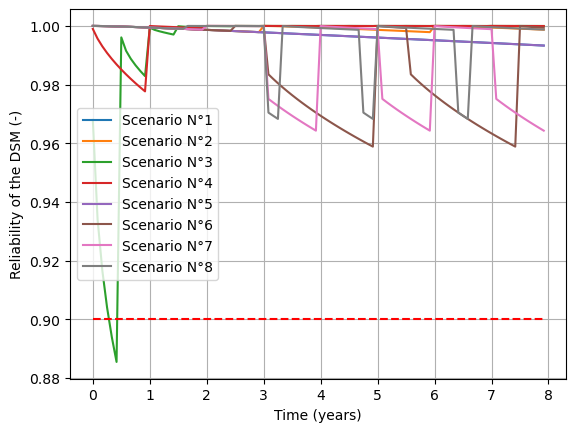

In [81]:
plt.figure(1)

for cont in range(len(R_simulation)):
    plt.plot(Time_months / year_to_month, R_simulation[cont], label=graph_labels[cont])
plt.plot(Time_months / year_to_month, np.ones(len(Time_months)) * 0.9, 'r--')
plt.xlabel('Time (years)')
plt.ylabel('Reliability of the DSM (-)')
plt.legend()
plt.grid(True)
plt.show()

### 4.2. Scenarios Comparison
In this table the configuration of each scenario is described based on the inputs given above.

In [82]:
markdown_table1 = df.to_markdown()
Markdown(markdown_table1)

|    |   Scenario |   Initial S/C Batch at $t_0$ | Subsystem Redundancy (EPS only)   | Phased Deployment Strategy   |   Relaunch Rate [months] |   Relaunch Amount [S/C] | Programmed Retirement   |
|---:|-----------:|-----------------------------:|:----------------------------------|:-----------------------------|-------------------------:|------------------------:|:------------------------|
|  0 |          1 |                            8 | False                             | False                        |                        1 |                       0 | False                   |
|  1 |          2 |                            8 | False                             | True                         |                       36 |                       8 | True                    |
|  2 |          3 |                            2 | False                             | True                         |                        6 |                       2 | True                    |
|  3 |          4 |                            4 | False                             | True                         |                       12 |                       4 | True                    |
|  4 |          5 |                            8 | False                             | False                        |                        1 |                       0 | True                    |
|  5 |          6 |                            8 | False                             | True                         |                       30 |                       4 | True                    |
|  6 |          7 |                            8 | False                             | True                         |                       24 |                       4 | True                    |
|  7 |          8 |                            8 | False                             | True                         |                       20 |                       4 | True                    |

### 4.3. Reliability Comparison
The reliability of the system in the different configurations are analyzed over different periods of time of the mission.

In [83]:
markdown_table2 = df1.to_markdown()
Markdown(markdown_table2)

|    |   Scenario |   Reliability at 6 months |   Reliability at 12 months |   Reliability at 18 months |   Reliability at 2 years |   Reliability at 3 years |   Reliability at 4 years |   Reliability at 5 years |   Reliability at 6 years |   Reliability at 7 years |   Reliability at 8 years |
|---:|-----------:|--------------------------:|---------------------------:|---------------------------:|-------------------------:|-------------------------:|-------------------------:|-------------------------:|-------------------------:|-------------------------:|-------------------------:|
|  0 |          1 |                    0.9998 |                     0.9994 |                     0.9991 |                   0.9987 |                   0.9978 |                   0.9969 |                   0.996  |                   0.9951 |                   0.9942 |                   0.9933 |
|  1 |          2 |                    0.9998 |                     0.9994 |                     0.9991 |                   0.9987 |                   1      |                   0.9994 |                   0.9987 |                   1      |                   0.9994 |                   0.9987 |
|  2 |          3 |                    0.9961 |                     0.9994 |                     0.9999 |                   1      |                   1      |                   1      |                   1      |                   1      |                   1      |                   1      |
|  3 |          4 |                    0.9851 |                     1      |                     0.9995 |                   1      |                   1      |                   1      |                   1      |                   1      |                   1      |                   1      |
|  4 |          5 |                    0.9998 |                     0.9994 |                     0.9991 |                   0.9987 |                   0.9978 |                   0.9969 |                   0.996  |                   0.9951 |                   0.9942 |                   0.9933 |
|  5 |          6 |                    0.9998 |                     0.9994 |                     0.9991 |                   0.9987 |                   1      |                   0.9694 |                   1      |                   0.9764 |                   0.9633 |                   0.9994 |
|  6 |          7 |                    0.9998 |                     0.9994 |                     0.9991 |                   1      |                   0.9999 |                   1      |                   0.9989 |                   1      |                   0.9989 |                   0.9643 |
|  7 |          8 |                    0.9998 |                     0.9994 |                     0.9991 |                   1      |                   0.9999 |                   0.9993 |                   1      |                   0.999  |                   0.9996 |                   0.9987 |

### 4.4. Cost Comparison
For every scenario three different cost models estimations are compared. Based on the information mentioned previously in launch costs, the model costs for the three scenarios are obtained this way.

The model called "Deployment Cost only POD" is calculated this way:
$$
    C_{DSM,only POD} = N_{sat,8y} * C_{POD}
$$

Furthermore, the model called "Deployment Cost SpaceX and POD" is calculated this way:
$$
    C_{DSM,SpaceXPOD} = C_{launch,SpaceX} \left \lceil \frac{N_{sat,t=0}}{8} \right \rceil + N_{sat,relaunch}N_{relaunch} C_{POD}
$$

Finally, the model called "Deployment Cost Only SpaceX" is calculated this way:
$$
    C_{DSM,SpaceX} = C_{launch,SpaceX}\left ( \left \lceil \frac{N_{sat,t=0}}{8} \right \rceil + \left \lceil \frac{N_{sat,relaunch}}{8} \right \rceil N_{relaunch} \right ) 
$$


In [84]:
markdown_table3 = df2.to_markdown()
Markdown(markdown_table3)

|    |   Scenario |   Deployment Cost Only POD [kUSD] |   Deployment Cost SpaceX and POD [kUSD] |   Deployment Cost Only SpaceX [kUSD] |   Total S/C Launched |   Active S/C at T-0 |   Active S/C at 6 months |   Active S/C at 12 months |   Active S/C at 18 months |   Active S/C at 24 months |   Active S/C at 3 years |   Active S/C at 4 years |   Active S/C at 5 years |   Active S/C at 6 years |   Active S/C at 7 years |   Active S/C at 8 years |
|---:|-----------:|----------------------------------:|----------------------------------------:|-------------------------------------:|---------------------:|--------------------:|-------------------------:|--------------------------:|--------------------------:|--------------------------:|------------------------:|------------------------:|------------------------:|------------------------:|------------------------:|------------------------:|
|  0 |          1 |                              1200 |                                     300 |                                  300 |                    8 |                   8 |                        8 |                         8 |                         8 |                         8 |                       8 |                       8 |                       8 |                       8 |                       8 |                       8 |
|  1 |          2 |                              3600 |                                    2700 |                                  900 |                   24 |                   8 |                        8 |                         8 |                         8 |                         8 |                      16 |                       8 |                       8 |                      16 |                       8 |                       8 |
|  2 |          3 |                              5100 |                                    5100 |                                 5100 |                   34 |                   2 |                        4 |                         6 |                         8 |                        10 |                      14 |                      14 |                      14 |                      14 |                      14 |                      12 |
|  3 |          4 |                              5400 |                                    5100 |                                 2700 |                   36 |                   4 |                        4 |                         8 |                         8 |                        12 |                      16 |                      16 |                      16 |                      16 |                      16 |                      12 |
|  4 |          5 |                              1200 |                                     300 |                                  300 |                    8 |                   8 |                        8 |                         8 |                         8 |                         8 |                       8 |                       1 |                       1 |                       1 |                       1 |                       1 |
|  5 |          6 |                              3000 |                                    2100 |                                 1200 |                   20 |                   8 |                        8 |                         8 |                         8 |                         8 |                      12 |                       4 |                       8 |                       4 |                       4 |                       8 |
|  6 |          7 |                              3600 |                                    2700 |                                 1500 |                   24 |                   8 |                        8 |                         8 |                         8 |                        12 |                      12 |                       8 |                       8 |                       8 |                       8 |                       4 |
|  7 |          8 |                              3600 |                                    2700 |                                 1500 |                   24 |                   8 |                        8 |                         8 |                         8 |                        12 |                      12 |                       8 |                       8 |                       8 |                       8 |                       8 |

## 5. References
Guo, J., Monas, L., & Gill, E. (2014). Statistical analysis and modelling of small satellite reliability. Acta Astronautica, 98, 97–110. https://doi.org/10.1016/j.actaastro.2014.01.018

Bouwmeester, J., Menicucci, A., & Gill, E. K. A. (2022). Improving CubeSat reliability: Subsystem redundancy or improved testing? Reliability Engineering & System Safety, 220, 108288. https://doi.org/10.1016/J.RESS.2021.108288

Menchinelli, A., Ingiosi, F., Pamphili, L., Marzioli, P., Patriarca, R., Costantino, F., & Piergentili, F. (2018). A reliability engineering approach for managing risks in CubeSats. Aerospace, 5(4). https://doi.org/10.3390/aerospace5040121

Kiselyov, I. (2020). Model-Based Reliability Engineering (Delft University of Technology). Retrieved from http://resolver.tudelft.nl/uuid:3083351a-dcd1-4bb7-8169-d13055a95388

Qaisar, S. U., Ryan, M. J., & Tuttle, S. L. (2016). A Framework for Small Satellite Architecture Design. INCOSE International Symposium, 26(1), 1747–1758. https://doi.org/10.1002/j.2334-5837.2016.00258.x

Nieto-Peroy, C., & Emami, M. R. (2019). CubeSat mission: From design to operation. Applied Sciences (Switzerland), 9(15), 1–24. https://doi.org/10.3390/app9153110

Villela, T., Costa, C. A., Brandão, A. M., Bueno, F. T., & Leonardi, R. (2019). Towards the Thousandth CubeSat: A Statistical Overview. International Journal of Aerospace Engineering, 2019, 1–13. https://doi.org/10.1155/2019/5063145